# XGBoost "is all you need": the case of forecasting transmitted heat energy in District Heating Systems

This article presents a comparative study of two distinct approaches, XGBoost and Long-Short Term Memory (LSTM), for forecasting transmitted heat energy in District Heating Systems (DHS). The objective of the work was to explore scenarios in which conventional ML algorithms demonstrate better performance over deep learning networks in time series forecasting and the associated benefits in terms of computational cost and environmental impact.

The study focuses on a real-world DHS dataset. Through experimentation and analysis, it is demonstrated that XGBoost consistently outperforms LSTM in this specific forecasting task where this difference is explained by the error distribution illustrating that LSTM makes more significant errors in the intervals of less data availability. The reduced computational demands of conventional ML approaches not only result in cost savings but also minimize the carbon footprint associated with data analysis tasks in energy systems.

## Is Deep Learning a solution that fits all?

The extreme popularity and availability of off-the-shelf deep learning algorithms and architectures today have created excitement and very high expectations related to quickly addressing different automation challenges in different industries. The promise of simplicity of use combined with performance already demonstrated mostly in the cases of language processing and computer vision, has led to a surge in applying these technologies across various sectors. These include healthcare, finance, automotive, and more, where they are being used for tasks like disease detection, financial forecasting, autonomous driving, and customer service automation. However, this enthusiasm must be tempered with a recognition of the complexities involved. Successful implementation often requires significant domain expertise, large amounts of high-quality data, and the ability to interpret and fine-tune models to specific needs. Moreover, issues like algorithmic bias, transparency, and ethical considerations pose additional challenges.

The reality is that while deep learning offers powerful tools, their effective application demands more care and more expertise. Quite often, Deep Learning architectures are tested quickly and applied without careful consideration and with prejudice driven by AI hype. This hasty adoption often leads to overlooking crucial aspects like algorithm suitability, data quality, and computational requirements. The result is systems that either underperform or consume excessive energy, thus negating the benefits of using AI.

This situation underscores the importance of a more measured approach to implementing Machine Learning solutions, one that involves thorough testing, consideration of environmental impact, and an understanding of the specific problem context. Moreover, it emphasizes the need for organizations to invest in building or acquiring the necessary expertise to harness the full potential of AI technologies effectively and sustainably.

Traditional ML algorithms are indeed competitive when compared to complex neural network algorithms in certain time series forecasting problems. This will be showcased on the example of forecasting transmitted heat energy in District Heating Systems.

## Description of experiment

Despite the maturity of District Heating systems (DHS), substantial opportunities exist for enhancing their operational efficiency. This particularly pertains to the reduction of fuel consumption costs and minimization of carbon emissions. A promising strategy involves capitalizing on the considerable potential for reengineering current short- and long-term operational strategies of DHS. This can be achieved through the utilization of precise heat demand forecasts. Such forecasts are crucial for optimizing heat production, which leads to reduced fuel consumption, waste, and CO2 emissions. Additionally, this approach ensures maximum consumer satisfaction and facilitates more effective planning for both short and long-term heat production.

In essence, the operation of District Heating System (DHS) plants involves either automated or semi-automated management of primary (at the plant level) and secondary (at the substations level) supply water temperatures, as well as water flow in the primary supply. The primary and secondary flows are closed loop and the energy from primary to secondary lines is exchanged through a heat exchanger. The management of supply water temperature is based on the collective DHS demand and prevailing weather conditions. The overall DHS demand is determined by the transmitted heat energy in the specified interval, namely the difference between the measurements of transmitted energy in the current and past timepoint, recorded at the calorimeter, located at the return primary line.

Presently, conventional DHSs are managed through a Supervisory Control And Data Acquisition (SCADA) system. This system integrates various sensors, control mechanisms, and algorithms that automatically modify operational parameters in response to sensor data. DHS control at the district heating substation levels (primary and secondary sides of DHS) is automated. This includes the implementation of appropriate hot water reset controls (outdoor air reset or control curve), often described as a regulation curve, used by SCADA system to deduce desired supply line water temperature based on the measured outside air temperature.

This work examines the potential to replace simplistic control curve with a model capable to forecast the transmitted energy based on the measured air temperature in the previous timepoint.

The selected comparative methods are stacked Long-Short Term Memory architecture and Gradient Boosting approach, namely its XGBoost implementation. The experiment involves preparing the data appropriately for each model, training both models, and then evaluating and comparing their performance using relevant metrics. Additionally, XGBoost model is optimized by finding the set of hyperparameters providing the best metrics. The method used was Bayesian optimization.

The metrics used were Root Mean Square Error (RMSE), Mean Absolute Error (MAE) and Coefficient of determination (R2 score). The coefficient of determination, often denoted as R<sup>2</sup> (R-squared) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. Additional metrics for comparison are time for training and inference on the test set. The experiment is carried out in Google Colab environment, using T4 GPU runtime.

Implementation of XGBoost for regression problems expects a structured dataset, not a time series. Transforming time series data into a format suitable for regression problems is a common approach in machine learning for forecasting and other time-dependent analyses. This process involves converting the sequential nature of time series data into a structured format that a regression model can understand. One standard method is to create lagged features, which are values from previous time steps used as separate input features. The number of lagged features (also known as the lag order) depends on the specific problem and how far back in the past the predictive patterns extend. Additionally, certain qualities of the times of the measured instances will be extracted and used as features, namely, hour of the day, day of the week and month.

## Implementation

Let's bring on the code now. First, we mount the Google Drive so to enable access to the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The neccessary Python packages are imported. Besides the standard ones, we also import functions for correlation and time series stationarity analysis, algorithms, metrics, model selection features and optimization.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import time
from IPython.display import Image, display, HTML
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping

Data from one substation, namely substation 9 from the local DHS, will be used for the experiment. Data included outside ambient temperature from the sensor located at the building facade, on the north side; temperatures of water in supply and return primary and secondary lines and transmitted energy, measured by the calorimeter located at the primary return line. Two heating seasons were considered for analysis, namely 2018/19 and 2019/20.

Data is loaded and the features that will not be used in model training are dropped. Transmitted energy in the selected timepoint is calculated as the difference of the energy reading in that timepoint and in the previous one.

In [ ]:
datapath_processed='/content/drive/MyDrive/Projects/FondZaNauku/Prizma/Research/Data/p9_processed.csv'

In [ ]:
df=pd.read_csv(datapath_processed)
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('Unnamed: 0',inplace=True)

df = df[(df.index < '2020-04-01')]

df['deltae']=(df['e'].shift(-1)-df['e'])*1000
df=df.drop(['trt','tns','tps','tnp','tpp','e'], axis=1)

<ipython-input-4-9756753e5f38>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deltae']=(df['e'].shift(-1)-df['e'])*1000


Only the period from November to March was considered in the analysis. Normally, heating season starts mid-October and lasts till mid-April. However, those periods are characterized by high variance in temperature, special regimes of operation and thus, will not be accounted for.

There were missing data in the dataset. This was due to the lack of 3G network connectivity at certain time points. Missing data were imputed by using linear interpolation.

In [ ]:
df = df[~((df.index.month >= 4) & (df.index.month <= 11))]

df.interpolate(method='linear', inplace=True)

The analysis will consider data of transmitted heating energy and outside temperature from two heating seasons, in total 5832 datapoints.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5832 entries, 2018-12-01 00:00:00 to 2020-03-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tsp     5832 non-null   float64
 1   deltae  5832 non-null   float64
dtypes: float64(2)
memory usage: 136.7 KB


Overall distribution of available data is displayed in the figure below, after resetting date time index in order to enable a continuous signal presentation. Also, zoomed in overlay plot illustrates the obvious association between the outside temperature and transmitted heat energy signals.

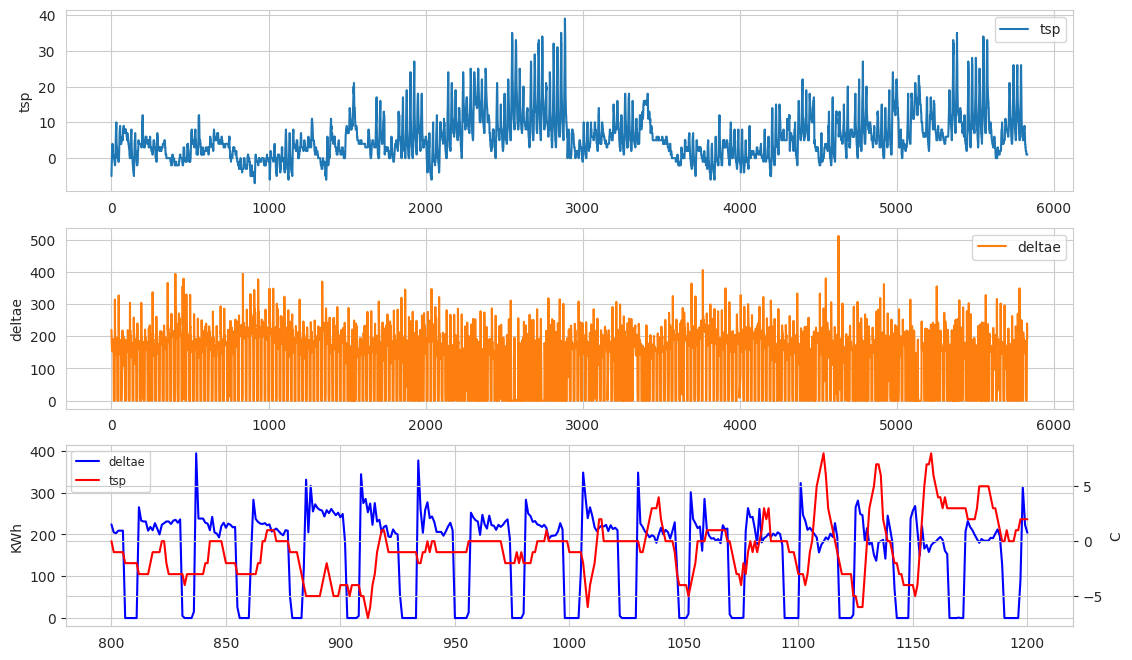

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(13, 8))  # 3 rows, 1 column

cols_plot = ['tsp', 'deltae']
df.reset_index(drop=True)[cols_plot].plot(subplots=True, ax=axes[:2])
for r, ax in enumerate(axes[:2]):
    ax.set_ylabel(cols_plot[r])

line1,=axes[2].plot(df.reset_index(drop=True).loc[800:1200, 'deltae'], label='deltae', color='b')
ax4=axes[2].twinx()
line2,=ax4.plot(df.reset_index(drop=True).loc[800:1200, 'tsp'], label='tsp', color='r')

lines = [line1, line2]
labels = [line.get_label() for line in lines]
axes[2].legend(lines, labels, loc='upper left', fontsize='small')
axes[2].grid(True)

axes[2].set_ylabel('KWh')
ax4.set_ylabel('C')

plt.show()

Both time series are stationary, which is confirmed by the Augmented Dickey-Fuller (ADF) test. In a stationary time series, the mean, variance, and autocorrelation structure remain constant across different time points. Stationarity is an important requirement for the good performance of parametric algorithms, such as neural networks.

In [ ]:
result_deltae = adfuller(df['deltae'])
print('ADF Statistic for deltae: %f' % result_deltae[0])
print('p-value for deltae: %f' % result_deltae[1])

result_tsp = adfuller(df['tsp'])
print('ADF Statistic for tsp: %f' % result_tsp[0])
print('p-value for tsp: %f' % result_tsp[1])

ADF Statistic for deltae: -5.552354
p-value for deltae: 0.000002
ADF Statistic for tsp: -5.907056
p-value for tsp: 0.000000


The distribution analysis of two relevant time series signals (distribution of data points - histogram, and the underlying probability density - Kernel Density Estimate plot are presented in a figure below) indicate relatively high sparsity of hourly transmitted energy feature, where zeros in certain time points indicate that the system is not operational, mostly in cases of high outside temperatures. When this is ignored, deltae signal exhibits normal distribution. Normal distribution is also exhibited by the outside temperature signal, with minor skewness towards higher temperatures.

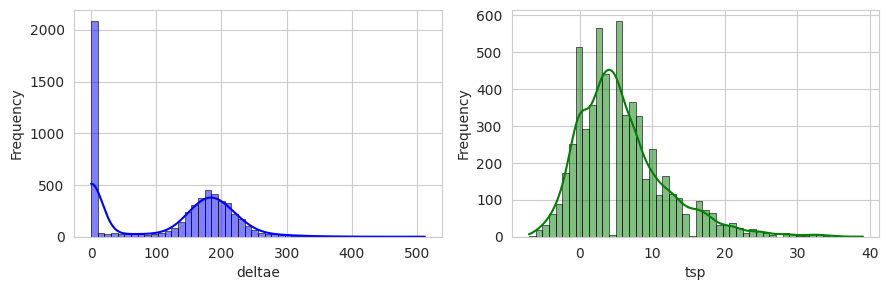

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

sns.histplot(df['deltae'], bins=50, kde=True, ax=axes[0], color='blue', edgecolor='black')
axes[0].set_xlabel('deltae')
axes[0].set_ylabel('Frequency')

sns.histplot(df['tsp'], bins=50, kde=True, ax=axes[1], color='green', edgecolor='black')
axes[1].set_xlabel('tsp')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The value of Spearman coefficient and p-value indicate that there is statistically significant negative association between two signals, which is expected. Even though both signals are normally distributed, Spearman values are considered instead of Pearson coefficients as more reliable indicator of association because of relatively high sparsity of deltae signal and zero data which can be also interpreted as outliers to which Spearman coefficient exhibits better response. Besides less sensitivity to outliers, the Spearman coefficient indicates monotonic relationship and does not assume linear association.

In [ ]:
spearman_corr, p_value = spearmanr(df['deltae'], df['tsp'])

print(f"Spearman Correlation Coefficient: {spearman_corr:.3f}")
print(f"P-value: {p_value:.3f}")

Spearman Correlation Coefficient: -0.308
P-value: 0.000


Two models and their respective forecasting capabilities will be tested with the data above, namely stacked LSTM model and XGBoost.

### Implementation of Stacked LSTM model

Long Short-Term Memory (LSTM) (Hochreiter and Schmidhuber, 1997) networks are a special kind of Recurrent Neural Network (RNN) (Rumelhart et al, 1985), specifically designed to learn from sequences of data and remember long-term dependencies in the data. They are widely used for sequence prediction problems, such as time series forecasting, natural language processing, and speech recognition. LSTMs are design to address the specific limitation of traditional RNNs related to struggling to capture long-term dependencies in a sequence due to the vanishing gradient problem.

LSTMs maintain a hidden state vector and a cell state vector across time steps, which help them store and manage long-term dependencies in the data. An LSTM unit consists of three main components: forget gate which "decides" what information should be thrown away or kept, input gate that updates the cell state, and output gate which "decides" what the next hidden state should be. In each time step, the LSTM cell takes three pieces of information: the current input data, the previous hidden state, and the previous cell state. Based on these inputs, it produces a new hidden state and a new cell state, which are passed to the next time step (see Figure below).

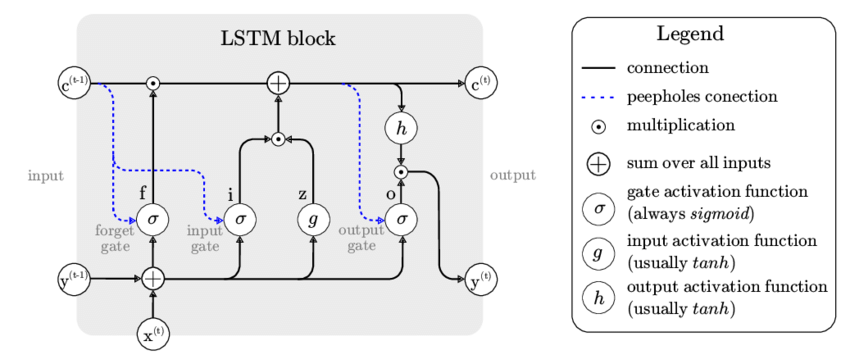

In [3]:
filename='/content/drive/MyDrive/Projects/FondZaNauku/Prizma/Research/Initial forecasting model/images/Architecture-of-a-typical-vanilla-LSTM-block.png'
display(Image(filename=filename, width=900))

Source: (Van Houdt et al, 2020)

LSTM networks take structured data transposed to supervised regression problem format by introducing certain number of datapoints from the past in one instance, namely lagged timepoints. For both experiments, 6 timepoints in the past will be considered in each data instance.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()

	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

80% of all data will be used for training, while 20% will be set aside for testing the trained model.

The fragment of the transposed data is shown in the table below.

In [ ]:
train_size=int(0.8*len(df))

n_features=2
n_hours=6

reframed = series_to_supervised(df.values, n_hours, 1, dropnan=True)
reframed=reframed.drop(columns=['var1(t)'])
reframed.head()

,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var2(t)
6,-5.0,220.0,-3.0,198.0,0.0,181.0,1.0,164.0,2.0,155.0,3.0,153.0,157.0
7,-3.0,198.0,0.0,181.0,1.0,164.0,2.0,155.0,3.0,153.0,4.0,157.0,167.0
8,0.0,181.0,1.0,164.0,2.0,155.0,3.0,153.0,4.0,157.0,4.0,167.0,170.0
9,1.0,164.0,2.0,155.0,3.0,153.0,4.0,157.0,4.0,167.0,3.0,170.0,174.0
10,2.0,155.0,3.0,153.0,4.0,157.0,4.0,167.0,3.0,170.0,2.0,174.0,164.0


For the case of training LSTM architecture, data will be normalized. Normalization is a crucial step for pre-processing data for training neural networks, as it improves gradient descent efficiency and effectiveness by preventing local minima.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed.values.astype('float32'))

Sets for training and testing are created.

In [ ]:
n_obs = scaled.shape[1]
train = scaled[:train_size, :]
test = scaled[train_size:, :]
train_X, train_y = train[:, :n_obs-1], train[:, n_obs-1]
test_X, test_y = test[:, :n_obs-1], test[:, n_obs-1]

LSTM layers expect data to be in a three-dimensional array format, typically represented as [samples, time steps, features], so the appropriate reshaping of train and test data is carried out.

In [ ]:
ttrain_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
ttest_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

The architecture used in the experiment is stacked LSTM, with two LSTM layers each with 100 units and Rectified Linear Unit activation, each followed with dropout layer. Mean absolute error is used as a loss function and efficient Adam optimizer has been used. Training is carried out with 100 epochs and batch size of 24, where 20% of the training set was used for validation.

In [ ]:
%%time
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(ttrain_X.shape[1], ttrain_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

start_time = time.time()
history = model.fit(ttrain_X, train_y, epochs=100, batch_size=24, validation_split=0.2, verbose=1, shuffle=False)
end_time = time.time()
lstm_execution_time = end_time - start_time
print(f"The LSTM training took {lstm_execution_time} seconds to execute")

Epoch 1/100
156/156 [==============================] - 10s 24ms/step - loss: 0.1472 - val_loss: 0.1118
Epoch 2/100
156/156 [==============================] - 3s 21ms/step - loss: 0.1020 - val_loss: 0.0936
Epoch 3/100
156/156 [==============================] - 5s 31ms/step - loss: 0.0921 - val_loss: 0.0806
Epoch 4/100
156/156 [==============================] - 4s 27ms/step - loss: 0.0858 - val_loss: 0.0759
Epoch 5/100
156/156 [==============================] - 3s 22ms/step - loss: 0.0822 - val_loss: 0.0668
Epoch 6/100
156/156 [==============================] - 3s 21ms/step - loss: 0.0769 - val_loss: 0.0640
Epoch 7/100
156/156 [==============================] - 5s 35ms/step - loss: 0.0752 - val_loss: 0.0636
Epoch 8/100
156/156 [==============================] - 4s 26ms/step - loss: 0.0741 - val_loss: 0.0642
Epoch 9/100
156/156 [==============================] - 4s 24ms/step - loss: 0.0726 - val_loss: 0.0665
Epoch 10/100
156/156 [==============================] - 10s 66ms/step - loss: 0.0

Model training and validation loss presented on a figure below demonstrate good generalization and it does not show overfitting, already mitigated by using dropout regularization in the model architecture.

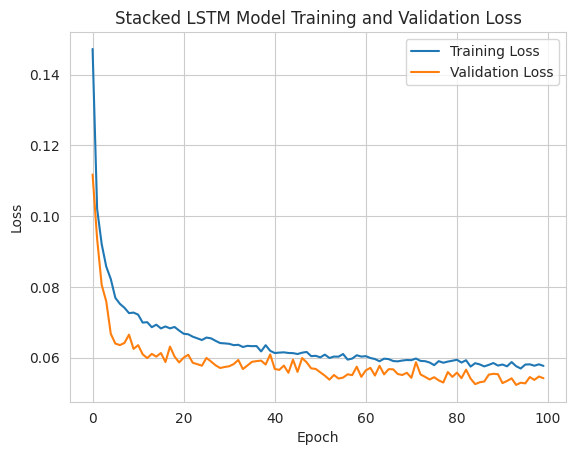

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Stacked LSTM Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

The performance of the model on test set is then measured. Before calculating RMSE, MAE and R2, scaled data is inverse-transformed to their original values.

In [ ]:
start_time = time.time()
yhat = model.predict(ttest_X)

tttest_X = ttest_X.reshape((ttest_X.shape[0], n_hours*n_features))
inv_yhat = np.concatenate((tttest_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

ttest_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((tttest_X, ttest_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_yhat = inv_yhat[:,n_hours*n_features]
inv_y = inv_y[:,n_hours*n_features]

end_time = time.time()
lstm_inference_time=end_time-start_time
print(f"The LSTM inference took {lstm_inference_time} seconds to execute")


lstm_rmse = mean_squared_error(inv_y, inv_yhat, squared=False)
lstm_mae = mean_absolute_error(inv_y, inv_yhat)
lstm_r2 = r2_score(inv_y, inv_yhat)

print("Root Mean Squared Error (RMSE):", lstm_rmse)
print("Mean Absolute Error (MAE):", lstm_mae)
print("R² Score:", lstm_r2)

37/37 [==============================] - 0s 4ms/step
The LSTM inference took 0.5367035865783691 seconds to execute
Root Mean Squared Error (RMSE): 62.111366
Mean Absolute Error (MAE): 28.889713
R² Score: 0.5399227711098082


Figure below illustrates the performance of the model in the zoomed-in period.

<function matplotlib.pyplot.show(close=None, block=None)>

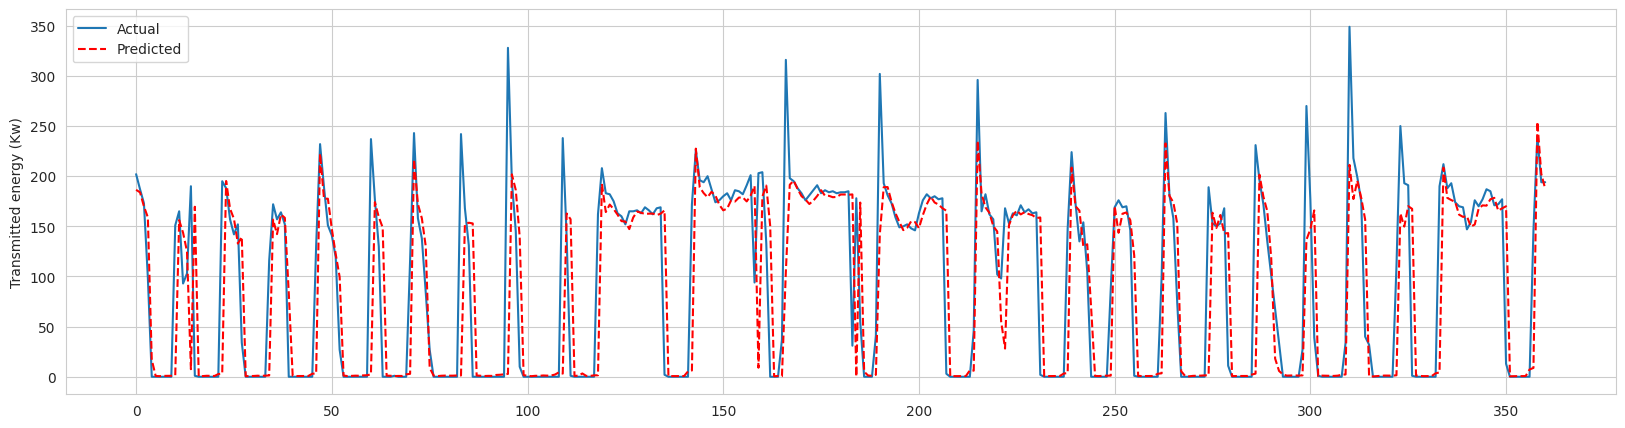

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(inv_y[800:1200])
plt.plot(inv_yhat[800:1200], color='red', linestyle='dashed')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.ylabel('Transmitted energy (Kw)')
plt.show

###Implementation of XGBoost model

XGBoost (Extreme Gradient Boosting) (Chen and Guestrin, 2016) is a highly efficient and flexible algorithm widely used for supervised learning tasks. It is an implementation of gradient boosted decision trees designed for speed and performance. XGBoost has gained popularity in machine learning competitions and practical applications due to its effectiveness and efficiency in handling various types of tabular data and relevant tasks.

XGBoost is an ensemble learning method, specifically a boosting technique. It builds the model in stages, and each stage adds new models to correct the errors made by the existing ensemble of models. It operates within the gradient boosting framework (Breiman, 1997) by constructing a new model that adds to an existing ensemble of models in a way that minimizes the overall prediction error. The "gradient boosting" part refers to the algorithm's use of the gradient descent algorithm to minimize the loss when adding new models. XGBoost primarily uses decision trees as its base learners. Each new tree corrects the residual errors (differences between predicted and actual values) of the previous trees. A key feature that differentiates XGBoost from other gradient boosting methods is its built-in regularization (both L1 and L2), which helps to prevent overfitting and improve model generalization. XGBoost can automatically handle missing data, making it robust to problems with incomplete datasets. It is optimized to efficiently handle sparse data (data with many zeros). It incorporates a learning rate (also called shrinkage), which scales the contribution of each new tree added to the model. This can be used to prevent overfitting.

Feature engineering practices ensure that time dimensions are accurately reflected in the relevant features. Given the cyclic nature of district heating systems operation, it is clear that hour of day is one of the most significant features. Besides that, relevance of day of the week is expected to be non-trivial, especially when considering if the day is a working day or not.

Similarly to what has been done in preparing the data for training of LSTM model, 6 timepoints in the past are considered in individual data instance.

In [ ]:
df['hour_of_day'] = df.index.hour
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['is_working_day'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)

df['deltae_forecast']=df['deltae']
df['deltae']=df['deltae'].shift(1)
df['deltae-1']=df['deltae'].shift(1)
df['deltae-2']=df['deltae'].shift(2)
df['deltae-3']=df['deltae'].shift(3)
df['deltae-4']=df['deltae'].shift(4)
df['deltae-5']=df['deltae'].shift(5)
df['deltae-6']=df['deltae'].shift(6)

df['tsp-1']=df['tsp'].shift(1)
df['tsp-2']=df['tsp'].shift(2)
df['tsp-3']=df['tsp'].shift(3)
df['tsp-4']=df['tsp'].shift(4)
df['tsp-5']=df['tsp'].shift(5)
df['tsp-6']=df['tsp'].shift(6)

df = df.dropna(axis=0, how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5825 entries, 2018-12-01 07:00:00 to 2020-03-31 23:00:00
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tsp              5825 non-null   float64
 1   deltae           5825 non-null   float64
 2   hour_of_day      5825 non-null   int64  
 3   month            5825 non-null   int64  
 4   day_of_week      5825 non-null   int64  
 5   is_working_day   5825 non-null   int64  
 6   deltae_forecast  5825 non-null   float64
 7   deltae-1         5825 non-null   float64
 8   deltae-2         5825 non-null   float64
 9   deltae-3         5825 non-null   float64
 10  deltae-4         5825 non-null   float64
 11  deltae-5         5825 non-null   float64
 12  deltae-6         5825 non-null   float64
 13  tsp-1            5825 non-null   float64
 14  tsp-2            5825 non-null   float64
 15  tsp-3            5825 non-null   float64
 16  tsp-4            5825 no

Spearman correlation coefficients show statistically significant association between hour of the day and month with transmitted heat energy. Interestingly, the hypothesis on the association between day of the week and transmitted heat energy was not confirmed.

In [ ]:
for f in ['hour_of_day','month','day_of_week','is_working_day']:
  spearman_corr, p_value = spearmanr(df['deltae'], df[f])
  print('----------')
  print(f)
  print(f"Spearman Correlation Coefficient: {spearman_corr:.3f}")
  print(f"P-value: {p_value:.3f}")

----------
hour_of_day
Spearman Correlation Coefficient: -0.339
P-value: 0.000
----------
month
Spearman Correlation Coefficient: -0.150
P-value: 0.000
----------
day_of_week
Spearman Correlation Coefficient: -0.025
P-value: 0.055
----------
is_working_day
Spearman Correlation Coefficient: 0.031
P-value: 0.018


Datetime index is reset and data is reshuffled.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

Initial model (with default hyperparameters) is trained and validated.

In [ ]:
X = df.drop('deltae_forecast', axis=1)
y = df['deltae_forecast']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time=time.time()
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
end_time=time.time()
xgb_execution_time=end_time-start_time
print(f"The XGB training took {xgb_execution_time} seconds to execute")

start_time=time.time()
y_pred = xgb_model.predict(X_test)
end_time=time.time()
xgb_inference_time=end_time-start_time
print(f"The XGB inference took {xgb_inference_time} seconds to execute")

xgb_mse = mean_squared_error(y_test, y_pred, squared=False)
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", xgb_mse)
print("Mean Absolute Error (MAE):", xgb_mae)
print("R² Score:", xgb_r2)

The XGB training took 0.238311767578125 seconds to execute
The XGB inference took 0.007272481918334961 seconds to execute
Root Mean Squared Error (RMSE): 36.700369608761356
Mean Absolute Error (MAE): 20.588544850070257
R² Score: 0.8532271168835299


For optimizing hyperparameters of XGBoost regressor, Bayesian approach was used. Bayesian optimization is an optimization strategy, particularly useful for Machine Learning scenarios where the evaluation of the objective function (such as model validation loss) is computationally expensive.

Bayesian optimization is a probabilistic model-based approach. It constructs a posterior distribution of functions (probability model) that best describes the function that needs optimization, based on past evaluations. The process is iterative, and it starts with a set of initial hyperparameter combinations (often chosen randomly). Then, modeling the objective function is carried out, by using the results from initial and ongoing evaluations.

In the case below, MAE is used as the objective function. The space of hyperparameters is defined. For implementation of the Bayesian optimization, Hyperopt (Bergstra et al, 2015) package is used. It is an open-source Python library used for optimizing the hyperparameters of machine learning algorithms. The Tree of Parzen Estimators (TPE) is used as an optimization algorithm. The optimization process is carried out in 80 iterations.

In [ ]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': params['gamma'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'min_child_weight': params['min_child_weight'],
        'learning_rate': params['learning_rate'],
        'n_estimators': int(params['n_estimators']),
    }

    clf = XGBRegressor(**params)

    score = cross_val_score(clf, X_train, y_train, scoring='neg_mean_absolute_error', cv=KFold(n_splits=3)).mean()
    return {'loss': -score, 'status': STATUS_OK}

space = {
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'gamma': hp.uniform('gamma', 0.1, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100)
}

start_time=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=80,
            trials=Trials())
end_time=time.time()
xgbopt_execution_time=end_time-start_time

print(f"The Hyperopt optimization took {xgbopt_execution_time} seconds to execute")
print("Best Hyperparameters:", best)

100%|██████████| 80/80 [09:09<00:00,  6.87s/trial, best loss: 20.865195870353787]
The Hyperopt optimization took 549.2373287677765 seconds to execute
Best Hyperparameters: {'gamma': 0.4430727543486341, 'learning_rate': 0.01096034101998716, 'max_depth': 9.0, 'min_child_weight': 3.9883807077671936, 'n_estimators': 800.0, 'reg_alpha': 0.436618599904243, 'reg_lambda': 0.6968546896870706}


Model is then trained with the best hyperparameters and tested on the adopted metrics.

In [ ]:
best_hyperparams = {
    'max_depth': int(best['max_depth']),
    'gamma': best['gamma'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_child_weight': best['min_child_weight'],
    'learning_rate': best['learning_rate'],
    'n_estimators': int(best['n_estimators']),
    'objective': 'reg:squarederror'
}

optimized_model = xgb.XGBRegressor(**best_hyperparams)
optimized_model.fit(X_train, y_train)

start_time=time.time()
y_pred = optimized_model.predict(X_test)
end_time=time.time()
xgbopt_inference_time=end_time-start_time
print(f"The optimized XGB inference took {xgbopt_inference_time} seconds to execute")

xgbopt_mse = mean_squared_error(y_test, y_pred, squared=False)
xgbopt_mae = mean_absolute_error(y_test, y_pred)
xgbopt_r2 = r2_score(y_test, y_pred)

print("MSE with optimized hyperparameters:", xgbopt_mse)
print("MAE with optimized hyperparameters:", xgbopt_mae)
print("R² Score with optimized hyperparameters:", xgbopt_r2)

The optimized XGB inference took 0.03481864929199219 seconds to execute
MSE with optimized hyperparameters: 35.67743003104617
MAE with optimized hyperparameters: 18.686795467870457
R² Score with optimized hyperparameters: 0.8612950131772577


###Discussion of results

The summary results are presented in table below.

XGBoost model clearly outperforms LSTM model in all metrics. Optimization somewhat improved the performance of the model with default set of hyperparameters.

In both cases, RMSE is almost double the Mean Absolute Error (MAE). RMSE gives more weight to larger errors due to the squaring of each error before averaging, while MAE treats all errors equally. RMSE being significantly higher than MAE suggests wider spread of errors or the presence of some large errors in predictions. In general, the model shows good accuracy, but it makes a few substantial errors.

In [ ]:
dfr = pd.DataFrame()

cr=0.0699 #in kg/h
faktor=cr*1000/3600 #in gr/sec

dfr['LSTM'] = [lstm_rmse,
                    lstm_mae,
                    lstm_r2,
                    lstm_execution_time,
                    lstm_inference_time,
                    lstm_execution_time*faktor,
                    lstm_inference_time*faktor*1000]
dfr['XGB'] = [xgb_mse,
                   xgb_mae,
                   xgb_r2,
                   xgb_execution_time,
                   xgb_inference_time,
                   xgb_execution_time*faktor,
                   xgb_inference_time*faktor*1000]
dfr['XGB Optimized'] = [xgbopt_mse,
                             xgbopt_mae,
                             xgbopt_r2,
                             xgbopt_execution_time,
                             xgbopt_inference_time,
                             xgbopt_execution_time*faktor,
                             xgbopt_inference_time*faktor*1000]
dfr.index = ['RMSE',
            'MAE',
            'R2',
            'Training time (in sec)',
            'Inference time (in sec)',
            'Training CO2 (in gr)',
            'Inference CO2 (per 1000, in gr)']

html_table = dfr.to_html(notebook=True)
display(HTML(html_table))

,LSTM (sec),XGB (sec),XGB Optimized (sec)
RMSE,62.111366,36.700370,35.677430
MAE,28.889713,20.588545,18.686795
R2,0.539923,0.853227,0.861295
Training time,476.128968,0.238312,549.237329
Inference time,0.536704,0.007272,0.034819
Training CO2 (in gr),9.244837,0.004627,10.664358
"Inference CO2 (per 1000, in gr)",10.420995,0.141207,0.676062


The histograms below show the distribution of errors (the differences between predicted and actual values) in case of optimized XGBoost and LSTM approach. The red dashed line at zero visualize the point where there is no error (perfect prediction). The Kernel Density Estimate (KDE) line provides a smooth curve representing the error density.

Error distribution histogram confirms the assumption on good accuracy with few substantial errors in using both approaches made earlier. However, it also explains the difference in performance of both methods. Occurrence of minor fat tails - increased accumulation of larger errors in case of LSTM models explains the source of difference in performance metrics: while LSTM model has more successful forecasts with less error, it also makes more substantial errors that affect the MAE and especially RMSE.

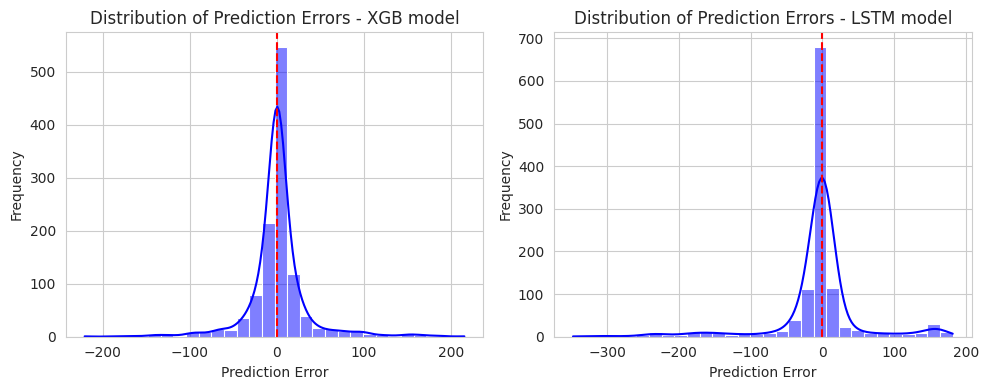

In [ ]:
xgb_errors = y_pred - y_test
lstm_errors = inv_yhat - inv_y

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(xgb_errors, kde=True, bins=30, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors - XGB model')
plt.axvline(x=0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
sns.histplot(lstm_errors, kde=True, bins=30, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors - LSTM model')
plt.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

The figure below shows the scatter plot of actual and predicted values for the optimized XGBoost model and LSTM model, as well as overlayed distribution of test data. The figure illustrates the accuracy of the model in the different intervals of test data. In both cases, the scatter plot points are clustered along the red line, which suggests the predictions are reasonably good.

However, there is some variance in both models (more significant in LSTM than XGBoost), especially for lower and higher values where the points tend to diverge more from the line. This variance can be explained by lack of data in intervals of lower and higher values for transmitted energy.

Additionally, scatter plots unveil the specific nature of significant errors made by both models, mostly due to impossibility to forecast the periods in which the heating is turned off by the operator (for XGBoost and LSTM models, concentration of forecasts along Y-axis) or to confusing those periods with periods in which the heating is actually on (LSTM models, concentration of forecasts along X-axis). It's worth highlighting that the decision to turn on the heating system lies with a human operator and it is affected by the reasons not included as features in this dataset.

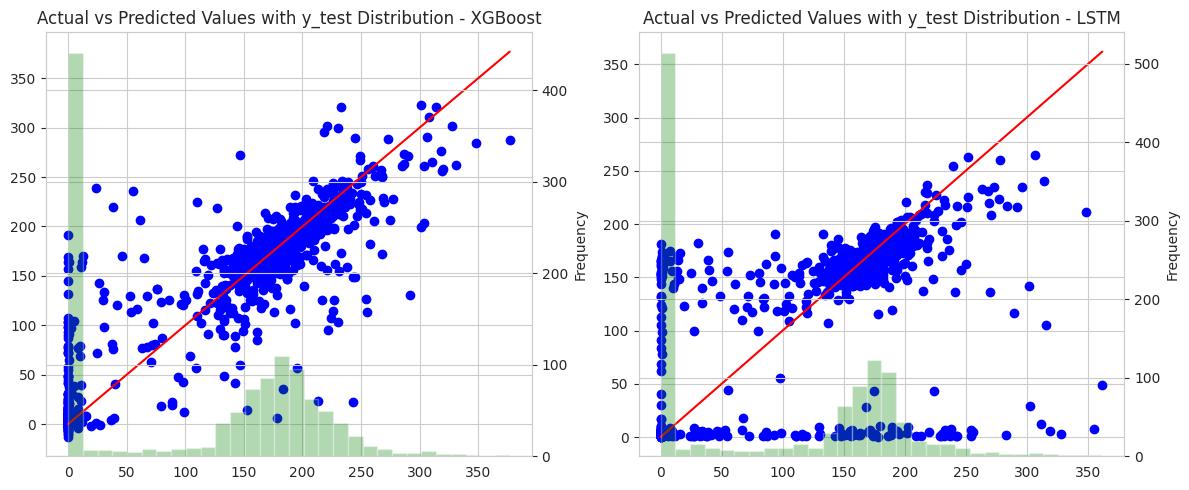

In [ ]:
xgb_errors = y_pred - y_test
lstm_errors = inv_yhat - inv_y

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Line')
ax2 = plt.twinx()
ax2.hist(y_test, bins=30, alpha=0.3, color='green', orientation='vertical')
plt.xlabel('Actual Values (y_test)')
ax2.set_ylabel('Frequency')
plt.title('Actual vs Predicted Values with y_test Distribution - XGBoost')


plt.subplot(1, 2, 2)
plt.scatter(inv_y, inv_yhat, color='blue', label='Predicted vs Actual')
plt.plot([min(inv_y), max(inv_y)], [min(inv_y), max(inv_y)], color='red', label='Ideal Line')
ax2 = plt.twinx()
ax2.hist(inv_y, bins=30, alpha=0.3, color='green', orientation='vertical')
plt.xlabel('Actual Values (y_test)')
ax2.set_ylabel('Frequency')
plt.title('Actual vs Predicted Values with y_test Distribution - LSTM')

plt.tight_layout()
plt.show()

In general, the LSTM models are expected to show good performance at uncovering very complex patterns of heat demand that occur at the beginning and end of the heating season, when heat demand, as well as outside temperature exhibit high variance. However, there is no sufficient data to unleash the power of LSTM's long-term memory in the case of this experiment.

Neural networks require data imputation. In this case, occasional missing data is replaced by using simplistic linear interpolation technique. It's worth highlighting that most of the existing data imputation approaches (besides stochastic ones) introduce regularities that are considered as bias that can lead to better results than in reality.

XGBoost assumes initial transformation of sequential time series data to structured, tabular data suitable for traditional regression problems. This appears very useful in industrial application where the periods of missing data due to sensor faults are frequent. Such faults and corresponding missing data problems cannot be addressed with imputation techniques, since those periods can be quite long. Ignoring sequential nature of data dramatically improves usability of data islands, occurring in such circumstances.

What are the possible reasons for XGBoost outperforming LSTM architecture in this case? First of the reasons is the size of the dataset combined with the time feature engineering practices. XGBoost can benefit significantly from good feature engineering if those features encapsulate the temporal dynamics well. LSTM is indeed very good in uncovering these dynamics, but only if there is sufficient data available. Second reason is that LSTMs can be particularly sensitive to the choice of hyperparameters, especially when considering the network topology. The optimization has not been done in this case as it would require significant computational resources and time.

Besides accuracy, computational requirements for the two methods are not comparable, especially when inference is considered. Training times in both cases appear to be similar, but only when optimization of hyperparameters is involved in XGBoost case.

The amount of energy used for training a neural network on a T4 GPU depends on several factors, including network architecture complexity, training dataset size, batch size, choice of optimizer and learning rate. Based on the technical specifications of the manufacturer (https://www.nvidia.com/en-eu/data-center/tesla-t4/) the power usage of NVidia T4 GPU is 70 watts, corresponding to the consumption of energy of 0.07 KWh. This accounts for low-power scenarios: for small, simple networks with small datasets and low batch sizes.

The average emission factor for CO2 emission for thermal power plants is 0.998 kg/kWh (Chowdhury et al, 2004), although the actual emissions may vary depending on the specific fuel mix and efficiency of the power plants used to generate the electricity.  Assuming the energy is produced by thermal plants, CO2 emission per unit time of ML training is 0.0699 kg/h. This calculation considers quite some simplifications, where the most significant are assumptions on: 1) constant GPU's consumption of energy, 2) same consumption of GPU and CPU, where latter is used for training of XGBoost model, 3) constant availability of resources making comparisons based on the times needed for training and inference questionable. However, for this purpose the results interpreted by adopting those assumptions provide a good enough indication when considering the convincing advantage that could be gained by appropriately choosing the approaches to solve time series forecasting problems, as presented in the table above.

<Figure size 800x300 with 0 Axes>

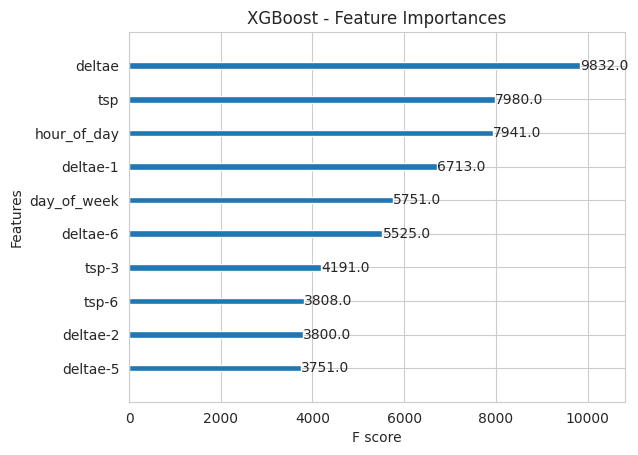

In [ ]:
plt.figure(figsize=(8, 3))
xgb.plot_importance(optimized_model, max_num_features=10)
plt.title("XGBoost - Feature Importances")
plt.show()

Finally, another advantage of conventional ML models is that they offer out-of-the-box functionality facilitating the interpretability of the models. The figure above shows the feature importances, as interpreted by the trained XGBoost model with optimal hyperparameters. The feature importance is typically represented by a metric called "F-score." The F-score is a measure of feature importance based on how often a feature is used to split data across all the trees in the ensemble (the boosted trees in the XGBoost model).

F-scores demonstrate the highest importance of the transmitted energy in the current hour, current ambient temperature and hour of the day.

##Conclusion

The challenges of high computational cost of the modern "off-the-shelf" deep learning architectures can be often addressed by considering the "cheaper" alternatives in very efficient conventional Machine Learning approaches. Indeed, such approaches must be the first choice in case of relatively smaller datasets and sometimes - datasets with sparse and/or missing data. On such sets, in most of the cases, conventional ML algorithms will not only appear as more sustainable in context of computational requirements but also more accurate. The necessary condition for this better performance are feature engineering practices that reflect the domain experience, expert knowledge on the internal and external factors affecting the time series data and expectations related to the behavior of the systems producing the data.

Finally, where trained deep learning architectures are often considered as "black-box" models, standard ML algorithms offer much better interpretability which is sometimes crucial in industrial applications. This interpretability is inherent and feature importances are easy to show.

##References

1.	Hochreiter, S., Schmidhuber, J. (1997) Long Short-Term Memory. Neural Computation 9, 1735-1780
2.	Rumelhart, D., Hinton, G., Williams, R. (1985). Learning internal representations by error propagation. Tech. rep. ICS 8504. San Diego, California: Institute for Cognitive Sci-ence, University of California.
3.	Van Houdt, G., Mosquera, C., Nápoles, G. A review on the long short-term memory model. Artif Intell Rev 53, 5929-5955 (2020). https://doi.org/10.1007/s10462-020-09838-1
4.	Chen, T., Guestrin, C. (2016) XGBoost: A Scalable Tree Boosting System. KDD '16: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. Pages 785-794. https://doi.org/10.1145/2939672.2939785
5.	Breiman, L. (June 1997). "Arcing The Edge" (PDF). Technical Report 486. Statistics Department, University of California, Berkeley.
6.	Bergstra, J., Komer, B., Eliasmith, C., Yamins, D., Cox, D. D. (2015). Hyperopt: A Python library for model selection and hyperparameter optimization. Computational Science & Discovery, 8(1), 014008. https://doi.org/10.1088/1749-4699/8/1/014008
7.	Chowdhury, S., Chakraborty, S., Bhattacharya, S., Garg, A., Mitra, A.P., Mukherjee, I., Chakraborty, N. (2004) An emission estimation of greenhouse gas emission from thermal power plants in India during 2002-03. In Proceedings, Workshop on Uncertainty Reduction in Greenhouse Gas Inventories. Ed.; A.P. Mitra, Subodh K. Sharma, S. Bhattachrya & A. Garg, Published by Ministry of Environment and Forests, Government of India, New Delhi, 2004; pp. 16-22.
